In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)
from lightgbm import LGBMRegressor
from prophet import Prophet
import shap 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set reproducibility
np.random.seed(42)

In [3]:
# Weather thresholds
HEATWAVE_THRESHOLD = 35  # °C
HEAVY_SNOW_THRESHOLD = 10  # cm

In [4]:
STATE_COORDINATES = {
    "CA": (36.7783, -119.4179),
    "TX": (31.9686, -99.9018),
    "WI": (43.7844, -88.7879),
}

In [5]:
# Load M5 dataset files
sales = pd.read_csv("/kaggle/input/m5-testing/sales_train_validation.csv")
calendar = pd.read_csv("/kaggle/input/m5-testing/calendar.csv")
prices = pd.read_csv("/kaggle/input/m5-testing/sell_prices.csv")

In [6]:
sales_long = pd.melt(
    sales,
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    var_name="d",
    value_name="sales"
)

calendar["date"] = pd.to_datetime(calendar["date"])
calendar = calendar[["d", "date", "weekday", "event_name_1", "event_type_1"]]
sales_long = sales_long.merge(calendar, on="d", how="left")

In [7]:
# Focus on one store
sales_long = sales_long[sales_long["store_id"] == "CA_1"]
sales_long["date"] = pd.to_datetime(sales_long["date"])

In [8]:
# Feature engineering
sales_long["day_of_week"] = sales_long["date"].dt.dayofweek
sales_long["month"] = sales_long["date"].dt.month
sales_long["is_weekend"] = (sales_long["day_of_week"] >= 5).astype(int)
sales_long["is_holiday"] = sales_long["event_name_1"].notnull().astype(int)
sales_long = sales_long.sort_values(["id", "date"])
sales_long["sales_lag7"] = sales_long.groupby("id")["sales"].shift(7)
sales_long["sales_rolling7"] = sales_long.groupby("id")["sales"].transform(lambda x: x.shift(1).rolling(7).mean())

In [9]:
features = ["day_of_week", "month", "is_weekend", "is_holiday", "sales_lag7", "sales_rolling7"]
target = "sales"
final_data = sales_long.dropna(subset=features + [target])
sales_data = final_data.copy()

In [10]:
print(" Final data ready:", final_data.shape)
print(final_data[["date", "item_id", "sales"] + features].head())

 Final data ready: (5811394, 18)
             date      item_id  sales  day_of_week  month  is_weekend  \
215042 2011-02-05  FOODS_1_001      2            5      2           1   
245532 2011-02-06  FOODS_1_001      0            6      2           1   
276022 2011-02-07  FOODS_1_001      0            0      2           0   
306512 2011-02-08  FOODS_1_001      0            1      2           0   
337002 2011-02-09  FOODS_1_001      0            2      2           0   

        is_holiday  sales_lag7  sales_rolling7  
215042           0         3.0        1.428571  
245532           1         0.0        1.285714  
276022           0         0.0        1.285714  
306512           0         1.0        1.285714  
337002           0         4.0        1.142857  


In [11]:
# Weather Integration 
def get_weather(lat, lon, start_date, end_date):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ["temperature_2m_max", "snowfall_sum"],
        "temperature_unit": "celsius",
        "timezone": "auto"
    }
    r = requests.get(url, params=params).json()
    return pd.DataFrame({
        "date": r["daily"]["time"],
        "tmax": r["daily"]["temperature_2m_max"],
        "snow": r["daily"]["snowfall_sum"]
    })

In [12]:
weather_dfs = []
for state_id, (lat, lon) in STATE_COORDINATES.items():
    w = get_weather(lat, lon, "2011-01-29", "2016-06-19")
    w["state_id"] = state_id
    weather_dfs.append(w)

weather = pd.concat(weather_dfs)
weather["date"] = pd.to_datetime(weather["date"])

sales_long["date"] = pd.to_datetime(sales_long["date"])
data = pd.merge(sales_long, weather, on=["date", "state_id"], how="left")
data["is_heatwave"] = (data["tmax"] > HEATWAVE_THRESHOLD).astype(int)
data["is_heavy_snow"] = (data["snow"] > HEAVY_SNOW_THRESHOLD).astype(int)
data.fillna({"is_heatwave": 0, "is_heavy_snow": 0}, inplace=True)
features += ["is_heatwave", "is_heavy_snow"]

In [13]:
# Train LightGBM
model = LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
tscv = TimeSeriesSplit(n_splits=3)
for fold, (train_idx, test_idx) in enumerate(tscv.split(data)):
    X_train = data.iloc[train_idx][features]
    y_train = data.iloc[train_idx][target]
    X_test = data.iloc[test_idx][features]
    y_test = data.iloc[test_idx][target]
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"Fold {fold+1} RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 1458185, number of used features: 7
[LightGBM] [Info] Start training from score 1.502508
Fold 1 RMSE: 3.1425
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 2916369, number of used features: 7
[LightGBM] [Info] Start training from score 1.907887
Fold 2 RMSE: 2.0100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.207762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co


LightGBM Feature Importance (SHAP) - Full Data


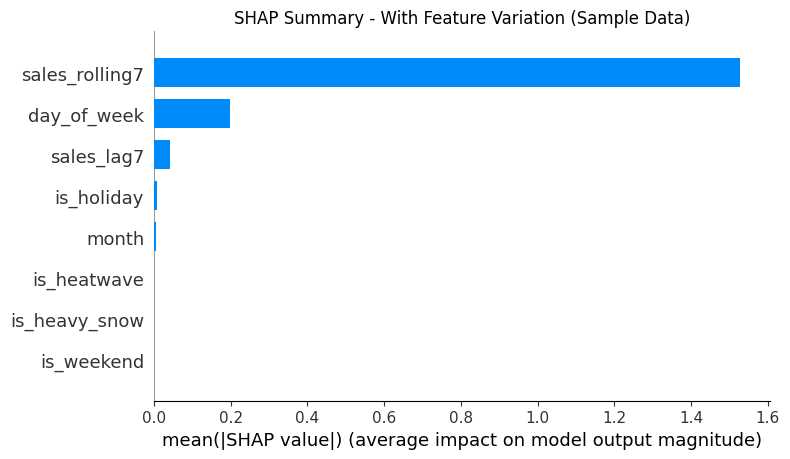

<Figure size 640x480 with 0 Axes>

In [14]:
# SHAP for full data
print("\nLightGBM Feature Importance (SHAP) - Full Data")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data[features])

shap.summary_plot(shap_values, data[features], plot_type="bar", show=False)
plt.title("SHAP Summary - With Feature Variation (Sample Data)")
plt.tight_layout()
plt.savefig("shap_full_data.png", dpi=300, bbox_inches="tight")
plt.show()
plt.clf() 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 1913, number of used features: 7
[LightGBM] [Info] Start training from score 0.785677

LightGBM SHAP - Single Item


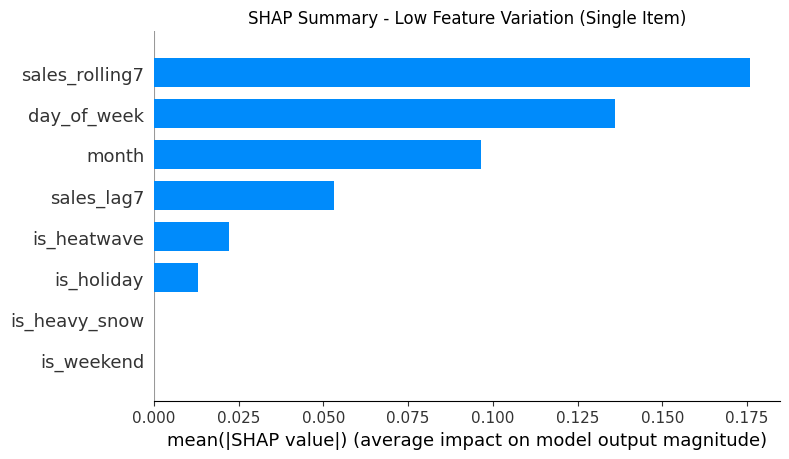

<Figure size 640x480 with 0 Axes>

In [16]:
# SHAP for single item
item = data["id"].unique()[0]
data_item = data[data["id"] == item]

model.fit(data_item[features], data_item[target])

print("\nLightGBM SHAP - Single Item")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_item[features])

shap.summary_plot(shap_values, data_item[features], plot_type="bar", show=False)
plt.title("SHAP Summary - Low Feature Variation (Single Item)")
plt.tight_layout()
plt.savefig("shap_single_item.png", dpi=300, bbox_inches="tight")
plt.show()
plt.clf()

In [17]:
data["base_pred"] = model.predict(data[features])

In [18]:
#Hybrid
data["prediction"] = data["base_pred"]
weekend_holiday = (data["is_holiday"] == 1) & (data["day_of_week"].isin([5, 6]))
data.loc[weekend_holiday, "prediction"] *= 1.5
data.loc[data["is_heatwave"] == 1, "prediction"] *= 0.8
data.loc[data["is_heavy_snow"] == 1, "prediction"] *= 0.7

In [19]:
# Train Prophet model
item = data["id"].unique()[0]
prophet_df = data[data["id"] == item][["date", "sales"]].rename(columns={"date": "ds", "sales": "y"})
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)
forecast_df = forecast[["ds", "yhat"]].rename(columns={"ds": "date", "yhat": "prophet_prediction"})
data = data.merge(forecast_df, on="date", how="left")

11:41:31 - cmdstanpy - INFO - Chain [1] start processing
11:41:31 - cmdstanpy - INFO - Chain [1] done processing


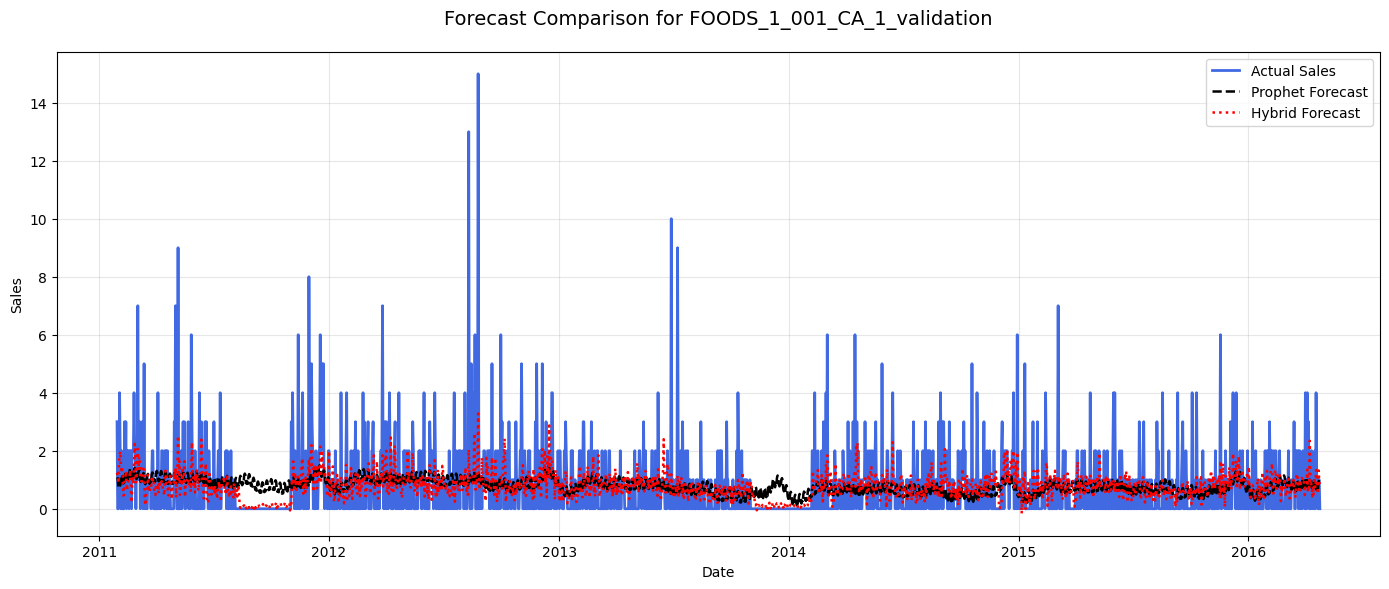

In [20]:
#Plot
plot_df = data[data["id"] == item]  

plt.figure(figsize=(14, 6))

# Actual Sales 
plt.plot(plot_df["date"], plot_df["sales"], label="Actual Sales", color='royalblue', linewidth=2)

# Prophet Prediction 
plt.plot(plot_df["date"], plot_df["prophet_prediction"], label="Prophet Forecast", linestyle="--", color='black', linewidth=1.8)

# Hybrid (LightGBM + Rules) 
plt.plot(plot_df["date"], plot_df["prediction"], label="Hybrid Forecast", linestyle=":", color='red', linewidth=1.8)

plt.title(f"Forecast Comparison for {item}", fontsize=14, pad=20)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 16, 'axes.labelsize': 14})
plt.savefig("Forecast Comparision.png", dpi=300, bbox_inches='tight')
plt.show()

In [21]:
#Naive baseline
item_data = data[data["id"] == item].copy()
item_data["naive_last_day"] = item_data["sales"].shift(1)
item_data["naive_last_week"] = item_data["sales"].shift(7)
item_data["naive_mean"] = item_data["sales"].expanding().mean()
item_data["naive_drift"] = item_data["sales"].shift(1) + (item_data["sales"].shift(1) - item_data["sales"].shift(2))

In [22]:
def mase(y_true, y_pred):
    n = len(y_true)
    d = np.abs(np.diff(y_true)).sum() / (n - 1)
    errors = np.abs(y_true - y_pred)
    return errors.mean() / d if d != 0 else np.nan

def rmsse(y_true, y_pred):
    n = len(y_true)
    denominator = np.sum(np.diff(y_true) ** 2) / (n - 1)
    numerator = np.mean((y_true - y_pred) ** 2)
    return np.sqrt(numerator / denominator) if denominator != 0 else np.nan

def wmape(y_true, y_pred):
    return 100 * np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) if np.sum(np.abs(y_true)) != 0 else np.nan

def theils_u(y_true, y_pred):
    numerator = np.sqrt(np.mean((y_true - y_pred) ** 2))
    denom = np.sqrt(np.mean(y_true ** 2)) + np.sqrt(np.mean(y_pred ** 2))
    return numerator / denom if denom != 0 else np.nan

In [23]:
def evaluate_all(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    overstock = np.mean((y_pred > y_true) & (y_true > 0)) * 100
    stockout = np.mean((y_pred < y_true) & (y_true > 0)) * 100
    cost_index = 0.3 * overstock + 0.7 * stockout
    mase_val = mase(y_true, y_pred)
    rmsse_val = rmsse(y_true, y_pred)
    wmape_val = wmape(y_true, y_pred)
    theils_val = theils_u(y_true, y_pred)
    return [rmse, mae, r2, overstock, stockout, cost_index, mase_val, rmsse_val, wmape_val, theils_val]


In [24]:
models = {
    "Naive (Last Day)": "naive_last_day",
    "Naive (Last Week)": "naive_last_week",
    "Naive (Mean)": "naive_mean",
    "Naive (Drift)": "naive_drift",
    "LightGBM": "base_pred",
    "Hybrid": "prediction",
    "Prophet": "prophet_prediction"
}


In [25]:
results = []
for name, col in models.items():
    if col in item_data.columns:
        y_true = item_data["sales"].fillna(0)
        y_pred = item_data[col].fillna(item_data[col].mean())
        metrics = evaluate_all(y_true, y_pred)
        results.append([name] + metrics)

columns = [
    "Model", "RMSE", "MAE", "R2", 
    "Overstock%", "Stockout%", "Cost_Index", 
    "MASE", "RMSSE", "WMAPE", "Theil's U"
]

metrics_df = pd.DataFrame(results, columns=columns).sort_values("RMSE")

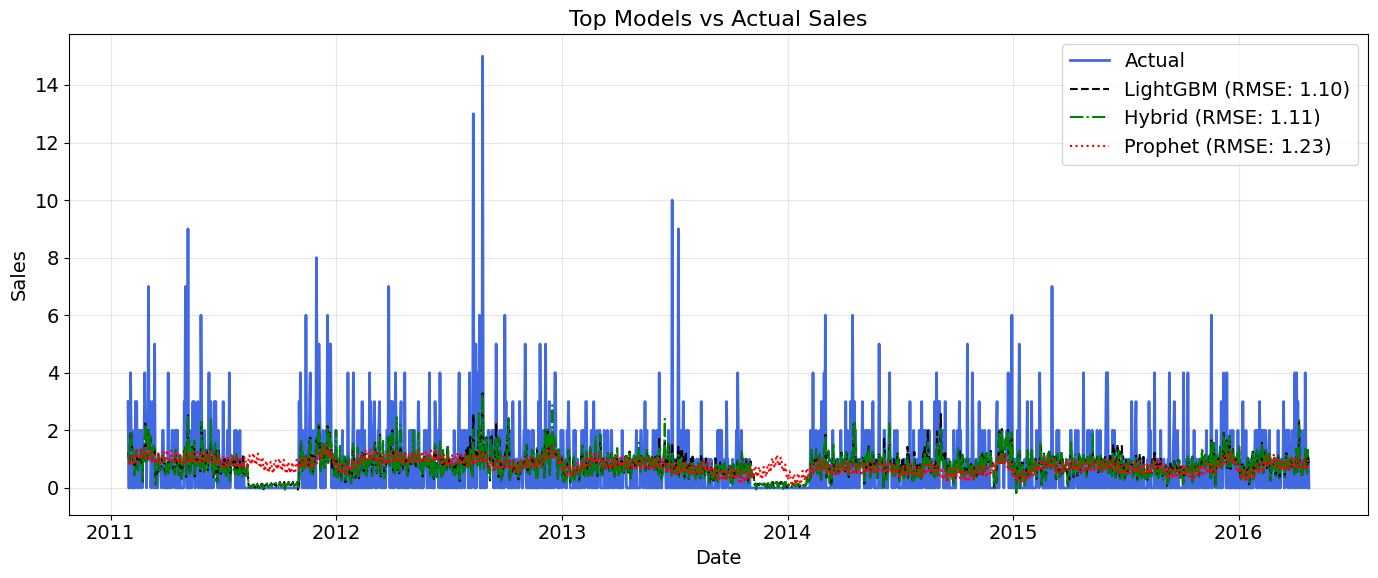

In [26]:
def plot_top_models(df, metrics, n_models=3):
    """Plot top performing models vs actual"""
    top_models = metrics.sort_values('RMSE').head(n_models)['Model'].values
    model_colors = ['black', 'green', 'red']

    plt.figure(figsize=(14, 6))
    plt.plot(df['date'], df['sales'], label='Actual', color='royalblue', linewidth=2)

    for i, model in enumerate(top_models):
        col = models[model]
        plt.plot(df['date'], df[col], 
                 label=f"{model} (RMSE: {metrics[metrics['Model'] == model]['RMSE'].values[0]:.2f})", 
                 linestyle=['--', '-.', ':'][i],
                 color=model_colors[i])

    plt.title("Top Models vs Actual Sales")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.rcParams.update({'font.size': 14, 'axes.titlesize': 16, 'axes.labelsize': 14})
    plt.savefig("Top Model vs Actual Sales Plot.png", dpi=300, bbox_inches='tight')
    plt.show()

# Plot
plot_top_models(item_data, metrics_df)

In [27]:
#Result table
cols = ["Model", "RMSE", "MAE", "R2", "Overstock%", "Stockout%", "Cost_Index", "MASE", "RMSSE", "WMAPE", "TheilsU"]

#Sort by RMSE
df_metrics = pd.DataFrame(results, columns=cols).sort_values("RMSE")

print(df_metrics.to_markdown(index=False))

# LaTeX version 
print(df_metrics.to_latex(index=False))

df_metrics.to_excel('model_comparison.xlsx', index=False)

markdown_table = df_metrics.to_markdown(index=False)

with open('model_comparison.txt', 'w') as f:
    f.write(markdown_table)

| Model             |    RMSE |      MAE |          R2 |   Overstock% |   Stockout% |   Cost_Index |     MASE |    RMSSE |    WMAPE |   TheilsU |
|:------------------|--------:|---------:|------------:|-------------:|------------:|-------------:|---------:|---------:|---------:|----------:|
| LightGBM          | 1.10339 | 0.740369 |  0.230366   |      7.0047  |     36.644  |      27.7522 | 0.7204   | 0.64548  |  94.2333 |  0.464853 |
| Hybrid            | 1.1115  | 0.739266 |  0.219002   |      6.53424 |     37.1145 |      27.9404 | 0.719327 | 0.650228 |  94.0929 |  0.47029  |
| Prophet           | 1.22705 | 0.845447 |  0.0481908  |      4.86147 |     38.7872 |      28.6095 | 0.822644 | 0.71782  | 107.607  |  0.531723 |
| Naive (Mean)      | 1.25465 | 0.900265 |  0.00488016 |      4.33873 |     39.1009 |      28.6722 | 0.875983 | 0.73397  | 114.585  |  0.520429 |
| Naive (Last Day)  | 1.70971 | 1.02834  | -0.847874   |      6.2206  |     28.8552 |      22.0648 | 1.0006   | 1.00018  | 1

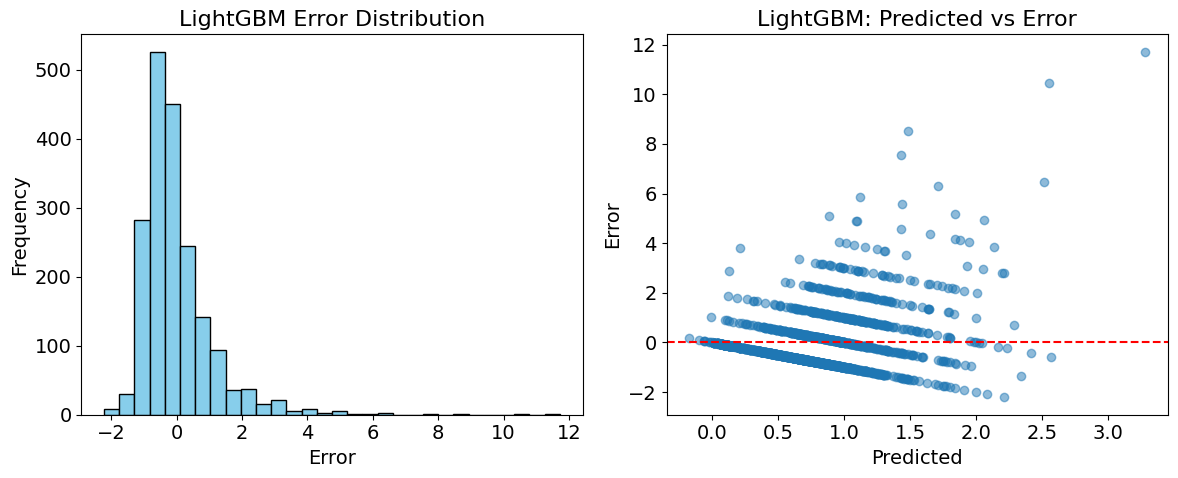

In [32]:
# The plot_error_distribution function is defined above:
def plot_error_distribution(df, model_name):
    """Visualize prediction errors"""
    col = models[model_name]
    errors = df['sales'] - df[col]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    # Using 'teal' for visual distinction from the default 'orange' Prophet plot
    plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"{model_name} Error Distribution")
    plt.xlabel("Error")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.scatter(df[col], errors, alpha=0.5)
    plt.axhline(0, color='red', linestyle="--")
    plt.title(f"{model_name}: Predicted vs Error")
    plt.xlabel("Predicted")
    plt.ylabel("Error")
    plt.tight_layout()
    # Updated filename to be specific to LightGBM
    plt.savefig(f"{model_name} Error distribution and Pred vs error.png", dpi=300, bbox_inches='tight')
    plt.show()

# Plot error for LightGBM
plot_error_distribution(item_data, 'LightGBM')

In [30]:
#Saving result
df_metrics.to_csv("model_comparison.csv", index=False)
item_data.to_csv("predictions_all.csv", index=False)